## CIFAR 10 RGB with selected finetuning

> Using **RGB improves accuracy**

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
from pathlib import Path
%matplotlib inline

### Data pipeline

In [2]:
file_path = "datasets/cifar-10-batches-bin/data_batch_*"
train_bins = glob.glob(file_path)


def cifar_dataset(files_list:list) -> tf.data.Dataset:

    data = tf.data.FixedLengthRecordDataset(files_list,1+3*32*32)
    data = data.map(lambda x: tf.decode_raw(x,tf.uint8),num_parallel_calls=4)
    data = data.map(lambda x: (x[1:],tf.expand_dims(x[0],0)),num_parallel_calls=4) 
    data = data.map(lambda x,y: (tf.reshape(x,(3,32,32)),y),num_parallel_calls=4)
    data = data.map(lambda x,y: (tf.transpose(x,(1,2,0)),y),num_parallel_calls=4)
    data = data.map(lambda x,y: (tf.image.convert_image_dtype(x,tf.float32),y),num_parallel_calls=4)
        
    return data

In [3]:
with tf.device('/cpu:0'):
    train_dataset = cifar_dataset(train_bins)
    train_dataset = train_dataset.shuffle(20000)
    train_dataset = train_dataset.repeat(20)
    train_dataset = train_dataset.batch(10)
    train_dataset = train_dataset.prefetch(2)

train_iterator = train_dataset.make_one_shot_iterator()

In [4]:
train_dataset.output_shapes, train_dataset.output_types

((TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(3)]),
  TensorShape([Dimension(None), Dimension(1)])),
 (tf.float32, tf.uint8))

**Check input** (Restart kernel and dont call this check before training)

(10, 32, 32, 3)
[[1 5 3 3 5 5 7 0 8 1]]


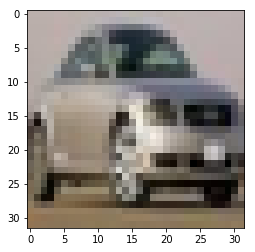

In [5]:
im,l = train_iterator.get_next()

with tf.Session() as sess:
    imr,lr = sess.run([im,l])

print(imr.shape)
print(lr.transpose())
plt.imshow(imr[0])

### Store the graph tensors

In [5]:
saver = tf.train.import_meta_graph('models/WT_TRANSFER/wt_transfer_eg.chpt.meta')

In [6]:
features = tf.get_collection('features')[0]
handle = tf.get_collection('handle')[0]
features,handle

(<tf.Tensor 'Dense_84/Tanh:0' shape=(?, 84) dtype=float32>,
 <tf.Tensor 'Placeholder:0' shape=() dtype=string>)

**Check loading**

**NOTE:** We do not have to restore model here, Since we had encoded the weights in the initializer

In [7]:
with tf.Session() as sess:
    #We do not have to restore model here, Since we had encoded the weights in the initializer
    sess.run(tf.global_variables_initializer())
    #Check if the right weights have been loaded
    print(sess.run(tf.get_collection('variables',scope='Conv2/bias')))
    
    hdl = sess.run(train_iterator.string_handle())
    out = sess.run(features,{handle:hdl})
out.shape

[array([-0.14805889,  0.6004731 ,  0.14357984, -0.3337978 , -0.48210445,
       -0.07447348, -0.3848596 , -0.07660984,  0.13621555,  0.2962938 ,
       -0.15078765, -0.14430566,  0.3739807 , -0.3766448 ,  0.60352474,
        0.4924152 ], dtype=float32)]


(10, 84)

### Classifier

In [8]:
classifier = tf.layers.dense(features,10,name="Dense_10")

In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(tf.get_collection('variables',scope='Conv2/bias')))
    hdl = sess.run(train_iterator.string_handle())
    print(sess.run(classifier,{handle:hdl}))

[array([-0.14805889,  0.6004731 ,  0.14357984, -0.3337978 , -0.48210445,
       -0.07447348, -0.3848596 , -0.07660984,  0.13621555,  0.2962938 ,
       -0.15078765, -0.14430566,  0.3739807 , -0.3766448 ,  0.60352474,
        0.4924152 ], dtype=float32)]
[[ 0.38436246 -0.9848181   0.43774337 -0.27235365  0.24708043  1.5685741
   1.0640831   0.8740437   0.72520876 -0.23361507]
 [ 1.3835859  -0.03470334  0.16692173  0.3610988   1.3948796   0.9293339
   0.66991484  1.490336    0.83381337  0.09766476]
 [ 0.9562899  -0.33107674  0.07098895  0.46104425  1.0214279   1.0215653
   0.3315633   1.3069373   0.64763457 -0.13627063]
 [ 0.2619238  -0.92574304  0.08024698 -0.05792682  0.79913044  1.7187195
   0.4629878   1.4401478   0.24595296 -0.41986147]
 [ 1.2477742  -0.61391795  0.1222094   0.6851812   1.1998534   1.4661864
   0.6664487   1.5278599   0.36762285  0.08682702]
 [ 1.1335326  -1.3194598  -0.02753893  0.05693829  0.47591993  1.6372643
   0.6378691   1.1559811   1.0294294   0.02697673]
 [

### Loss and optimizer

In [10]:
label = tf.get_collection('target')[0]

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(label,10),logits=classifier))
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

### Train

**IMPORTANT**: Use a new saver and dont mix up with meta graph saver. It wont contain **classifier** and other tensors created in this graph

In [11]:
!rm models/CIFAR10_rbg/*

rm: cannot remove 'models/CIFAR10_rbg/*': No such file or directory


In [12]:
#We need a new saver as we have created new variables
saver = tf.train.Saver()

import time

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    hdl = sess.run(train_iterator.string_handle())
    
    start = time.time()
    try:
        i = 1
        tmp = []
        while True:
            i = i+1
            l,_ = sess.run([loss,train],{handle:hdl})
            tmp.append(l)
            if i%5000 == 0:
                avg_loss = np.array(tmp).mean()
                print("Batch: ",i,avg_loss)
                tmp = []
                
    except tf.errors.OutOfRangeError:
        pass
    
    end = time.time()
    elapsed = end-start
    print("Elapsed time : ", elapsed, " s")
    saver.save(sess,'models/CIFAR10_rbg/cifar_model.ckpt')
    

Batch:  5000 1.7028109
Batch:  10000 1.2507287
Batch:  15000 1.1287763
Batch:  20000 1.0751923
Batch:  25000 1.0378172
Batch:  30000 1.0118082
Batch:  35000 0.98716116
Batch:  40000 0.96488494
Batch:  45000 0.9459721
Batch:  50000 0.9259637
Batch:  55000 0.9051121
Batch:  60000 0.8892301
Batch:  65000 0.87168205
Batch:  70000 0.85335153
Batch:  75000 0.839085
Batch:  80000 0.82521397
Batch:  85000 0.8108206
Batch:  90000 0.795145
Batch:  95000 0.7795058
Batch:  100000 0.7685578
Elapsed time :  130.98679304122925  s


### Evaluation

In [13]:
with tf.device('/cpu:0'):
    test_dataset = cifar_dataset(['datasets/cifar-10-batches-bin/test_batch.bin'])
    test_dataset = test_dataset.batch(10)
    test_dataset = test_dataset.prefetch(2)
    
test_iterator = test_dataset.make_one_shot_iterator()

In [14]:
def get_accuracy(predict:'eg: [2,4,1,...]',true: 'eg: [2,4,1,...]') -> int:
    correct_pred = tf.equal(predict,true)
    #We have to cast [True,False,True,...] --> [1,0,1...]
    acc = tf.reduce_mean(tf.cast(correct_pred,tf.float32))
    return acc



with tf.Session() as sess:
    saver.restore(sess,'models/CIFAR10_rbg/cifar_model.ckpt')
    hdl = sess.run(test_iterator.string_handle())
    
    
    #IMPORTANT:
    #Dont place this code inside the loop! This will slow down everything
    acc = get_accuracy(tf.argmax(classifier,axis=1),tf.transpose(tf.argmax(tf.one_hot(label,10),axis=2)))
    
    try:
        i = 0
        acc_list = []
        while True:
            i = i+1
            a = sess.run(acc,{handle:hdl})
            acc_list.append(a)
            if i%100 == 0:
                print(i, "Mean Acc : ", np.array(acc_list).mean())
                acc_list = []
                           
    except tf.errors.OutOfRangeError:
        pass 

INFO:tensorflow:Restoring parameters from models/CIFAR10_rbg/cifar_model.ckpt
100 Mean Acc :  0.565
200 Mean Acc :  0.576
300 Mean Acc :  0.565
400 Mean Acc :  0.566
500 Mean Acc :  0.594
600 Mean Acc :  0.577
700 Mean Acc :  0.552
800 Mean Acc :  0.579
900 Mean Acc :  0.574
1000 Mean Acc :  0.564


### Serving

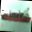

In [15]:
Image.open("pics/cifar22.png") #ship - 8

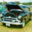

In [16]:
Image.open("pics/cifar3.png") #automobile - 1

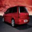

In [17]:
Image.open("pics/cifar24.png") #automobile - 1

In [22]:
test_ims_paths = tf.placeholder(tf.string)
serving_data = tf.data.Dataset.from_tensor_slices(test_ims_paths)

def read_img(filepath):
    image_string = tf.read_file(filepath)
    image = tf.image.decode_png(image_string)
    image = tf.image.convert_image_dtype(image,tf.float32)
    #image = tf.image.resize_images(image,(32,32))
    return image
    
serving_data = serving_data.map(lambda x: read_img(x))
serving_data = serving_data.map(lambda x: (x,tf.expand_dims(tf.cast(0,tf.uint8),axis=0)))#To match with iterator
serving_data = serving_data.batch(5)

**NOTICE**: The tensor shape **None** matches with the original **32,32**

In [23]:
serving_data.output_shapes,serving_data.output_types

((TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(None)]),
  TensorShape([Dimension(None), Dimension(1)])),
 (tf.float32, tf.uint8))

In [24]:
serving_iterator = serving_data.make_initializable_iterator()

In [25]:
with tf.Session() as sess:
    saver.restore(sess,'models/CIFAR10_rbg/cifar_model.ckpt')

    ims_paths = ["pics/cifar22.png","pics/cifar3.png","pics/cifar24.png"]
    hdl,_ = sess.run([serving_iterator.string_handle(),serving_iterator.initializer],{test_ims_paths:ims_paths})
    predictions = tf.argmax(classifier,axis=1)
    out = sess.run(predictions,{handle:hdl})
    print(out) 

INFO:tensorflow:Restoring parameters from models/CIFAR10_rbg/cifar_model.ckpt
[8 1 1]


## Summary

> 1) **Restore checkpoint** only when you want to use weights in the checkpoint. In this example, we had included the weights as a part of **initializers**. Hence we did not have to restore chpt before training!

> 2) Create a new saver to save trained model and dont mess up with the meta graph import saver

>3) Do not call the **get_next** of child iterators when using **feedable iterators**

> 4) Using **RGB** imporves **Accuracy**